<h1> <center> CNN: альтернативные нейросетевые модели <br> для последовательных данных </center></h1>

Рассмотрим применение свёрточных нейросетей к последовательным данным на примере моделей [TCN](https://arxiv.org/pdf/1803.01271.pdf) и [GatedCNN](https://arxiv.org/pdf/1612.08083.pdf) и сравним их с классическим подходом в виде LSTM.

Рассматривается задача word language modeling - научиться предсказывать слово по его контексту: $p(y^{t+1}|y^{1}, \dots, y^{t})$

Качество измеряется перплексией: $ppl = \prod\limits_{t=1}^T \Big(\dfrac{1}{\sum_{j=1}^{|V|} y_j^t \hat y_j^t  } \Big)$, где $T$ - число слов, $V$ - размер словаря

In [1]:
import os

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

from time import time
from data import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (10, 5), 
        "axes.titlesize" : 18 
    }
)
sns.set_style("whitegrid", {'axes.grid' : False})

Загружаем датасет Penn Tree Bank

In [3]:
corpus = Corpus('./data', rare_limit=1)
# длина последовательности
sequence_length = 80

In [4]:
# размер батча для обучения
batch_size = 16
# размер батча для валидации и теста
eval_batch_size = 10
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [5]:
data, targets = get_batch(train_data, 0, sequence_length)
data.shape, targets.shape

(torch.Size([16, 80]), torch.Size([16, 80]))

In [6]:
train_data.shape

torch.Size([16, 58099])

In [7]:
pad_idx = corpus.dictionary.word2idx['<pad>']
pad_idx

0

Размер словаря

In [8]:
vocab_size = len(corpus.dictionary)
vocab_size

10001

## Gated CNN

In [9]:
class GatedCNN(nn.Module):
    '''
    Модель на основе GLU и masked свёрток, в основе статья 
    "Language Modeling with Gated Convolutional Networks".
    '''
    def __init__(self, vocab_size, embed_dim=128,
                 convs_params=((300, 4),) * 3, num_residual = 2):
        '''
        Параметры:
        vocab_size: размер словаря
        embed_dim: размерность эмбеддингов
        convs_params: параметры свёрток, список из элементов (разменость выходного канала, размер фильтра)
        num_residual: число residual connections   
        '''
        super(GatedCNN, self).__init__()
        
        self.num_residual = num_residual
        
        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        
        in_channels = embed_dim
        self.convolutions = nn.ModuleList()
        for (out_channels, kernel_size) in convs_params:
            # padding для masked свёртки
            pad = (kernel_size - 1)                
            self.convolutions.append(
                nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels * 2, kernel_size, padding=pad)))
            in_channels = out_channels
            
        self.fc = nn.Linear(out_channels, vocab_size)        
        # для residual connection между слоями с разными разменостями
        self.proj = nn.Conv1d(embed_dim, out_channels, 1)
        self.init_weights()

    def init_weights(self):
        for conv in self.convolutions:
            conv.weight.data.normal_(0, 0.01)  
        
        self.embeddings.weight.data.normal_(0, 0.01)
        self.fc.weight.data.normal_(0, 0.01)
        self.fc.bias.data.fill_(0)
        
    def forward(self, x):
        # x размера (batch_size, sequence_len)
        batch_size, sequence_len = x.shape
        
        # слой эмбеддингов
        out = self.embeddings(x) # x размера (batch_size, sequence_len, embed_size) 
        
        # транспонируем для дальнейших свёрток
        out = out.transpose(1, 2) # x размера (batch_size, embed_size, sequence_len)
        
        residual = self.proj(out)
        # cсвёртки
        for i, conv in enumerate(self.convolutions):
            out = conv(out)
            # GLU
            out = F.glu(out, dim=1)[..., :sequence_len]
            
            # residual connection
            if i % self.num_residual == 0:
                out += residual
                residual = out
       
        out = out[..., :sequence_len]
        out = out.transpose(1, 2) # x размера (batch_size, sequence_len, embed_size)
        out = self.fc(out)
        return out.contiguous()

Обучение модели

In [10]:
def train(model, num_epoch, clip=0.1, print_every=100):
    model.train()
    all_loss = []
    all_time = []
    
    total_loss = 0
    start_time = time()
    
    if model.__class__.__name__ == 'LSTM':
        h = model.init_hidden(batch_size)
        
    for batch_idx, i in enumerate(range(0, train_data.size(1) - 1, sequence_length // 2)):
        data, targets = get_batch(train_data, i, sequence_length)
        optimizer.zero_grad()
        if model.__class__.__name__ == 'LSTM':
            # сохраняем в отдельную переменную, чтобы не пересчитывать всю историю
            h = (Variable(h[0].data), Variable(h[1].data))
            output, h = model(data, h)
        else:
            output = model(data)

        final_target = targets.contiguous().view(-1)
        final_output = output.contiguous().view(-1, vocab_size)
        loss = criterion(final_output, final_target)

        loss.backward()
        if clip > 0:
            # обрезаем градиенты
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.data

        if batch_idx % print_every == 0 and batch_idx > 0:
            all_loss.append(total_loss[0] / print_every)
            all_time.append(time() - start_time)
            print('epoch {:3d} | {:5d}/{:5d} batches |  ms/batch {:5.5f} | loss {:5.2f} | ppl {:8.2f}'.format(
                                                num_epoch, batch_idx, 2 * train_data.size(1) // sequence_length, 
                                                all_time[-1] / print_every, all_loss[-1], np.exp(all_loss[-1])))
            total_loss = 0
            start_time = time()
    return all_loss, all_time

In [11]:
def evaluation(model, eval_data):
    model.eval()
    total_loss = 0
    
    if model.__class__.__name__ == 'LSTM':
        h = model.init_hidden(eval_batch_size)
        
    for batch_idx, i in enumerate(range(0, eval_data.size(1) - 1, sequence_length // 2)):
        data, targets = get_batch(eval_data, i, sequence_length)
        optimizer.zero_grad()
        if model.__class__.__name__ == 'LSTM':
            # сохраняем в отдельную переменную, чтобы не пересчитывать всю историю
            h = (Variable(h[0].data), Variable(h[1].data))
            output, h = model(data, h)
        else:
            output = model(data)

        final_target = targets.contiguous().view(-1)
        final_output = output.contiguous().view(-1, vocab_size)
        loss = criterion(final_output, final_target)
        total_loss += loss.data[0]
    return total_loss / batch_idx

In [12]:
def train_model(model, lr= 0.001, clip=0.1, print_every=500):
    all_loss = []
    all_times = []
    val_losses = []
    epoch_time = []
    
    for num_epoch in range(1, epochs + 1):
        epoch_start_time = time()
        
        losses, times = train(model, num_epoch, clip=clip, print_every=print_every)
        all_loss.append(losses)
        all_times.append(times)
        epoch_time.append(time() - epoch_start_time)
        # валидация
        val_loss = evaluation(model, val_data)
        val_losses.append(val_loss)
        print('-' * 85)
        print(' end of epoch {:3d}  time for epoch: {:5.2f}  valid loss {:5.2f}  valid ppl {:8.2f}'.format(
                                                            num_epoch, epoch_time[-1], val_loss, np.exp(val_loss)))
        print('-' * 85)
        
        # Уменьшаем lr, если качество на валидации перестаёт улучшаться
        if num_epoch > 5 and val_loss >= max(val_losses[-3:]):
            lr = lr / 4.
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    return all_loss, all_times, val_losses, epoch_time

In [13]:
def count_params(model):
    '''
    Вычисляет число параметров модели
    '''
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [14]:
epochs = 20
criterion = nn.CrossEntropyLoss()
lr = 0.0001

In [15]:
gated_model = GatedCNN(vocab_size).cuda()
optimizer = optim.Adam(gated_model.parameters(), lr=lr) 
count_params(gated_model)

6079929

In [16]:
gated_all_loss, gated_all_times, gated_val_losses, gated_epoch_time = train_model(gated_model, lr)

epoch   1 |   500/ 1452 batches |  ms/batch 0.01337 | loss  6.85 | ppl   940.06
epoch   1 |  1000/ 1452 batches |  ms/batch 0.01076 | loss  6.37 | ppl   582.86
-------------------------------------------------------------------------------------
 end of epoch   1  time for epoch: 16.80  valid loss  6.16  valid ppl   475.50
-------------------------------------------------------------------------------------
epoch   2 |   500/ 1452 batches |  ms/batch 0.01108 | loss  6.05 | ppl   422.53
epoch   2 |  1000/ 1452 batches |  ms/batch 0.01060 | loss  5.94 | ppl   381.06
-------------------------------------------------------------------------------------
 end of epoch   2  time for epoch: 15.69  valid loss  5.93  valid ppl   377.81
-------------------------------------------------------------------------------------
epoch   3 |   500/ 1452 batches |  ms/batch 0.01095 | loss  5.78 | ppl   324.19
epoch   3 |  1000/ 1452 batches |  ms/batch 0.01089 | loss  5.67 | ppl   289.69
------------------

In [17]:
test_loss = evaluation(gated_model, test_data)
test_loss, np.exp(test_loss)

(5.351720036812199, 210.97086361578897)

## LSTM

In [18]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, n_hidden=256, n_layers=2, drop_rate=0.1):
        '''
        Параметры:
        vocab_size: размер словаря
        embed_dim: размерность эмбеддингов
        n_hidden: размерность скрытого слоя
        n_layers: число реккурентных слоёв
        drop_rate: dropout rate 
        '''
        super().__init__()
        self.drop_rate = drop_rate
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(drop_rate)
        self.lstm = nn.LSTM(embed_dim, n_hidden, n_layers, dropout=drop_rate, batch_first=True)
        self.fc = nn.Linear(n_hidden, vocab_size)
        
        self.init_weights()
        
    def forward(self, x, hc):
        '''
        Параметры:
        x: текущие данные
        hc: прошлый скрытый слой
        '''
        out = self.embeddings(x)        
        out, h = self.lstm(out, hc)
        out = self.dropout(out)
        
        # Соединяем выходы слоёв LSTM
        out = out.view(out.size()[0]*out.size()[1], self.n_hidden)
        
        out = self.fc(out)        
        return out, h

    
    def init_weights(self):       
        initrange = 0.1
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, sequence_len):
        ''' 
        Инициализация скрытого состояния и состояния ячейки
        Параметры:
        sequence_len: длина последовательности
        '''
        weight = next(self.parameters()).data
        return (Variable(weight.new(self.n_layers, sequence_len, self.n_hidden).zero_()),
                Variable(weight.new(self.n_layers, sequence_len, self.n_hidden).zero_()))

In [19]:
lstm_model = LSTM(vocab_size).cuda()
optimizer = optim.Adam(lstm_model.parameters(), lr=lr) 
count_params(lstm_model)

4771985

In [20]:
lstm_all_loss, lstm_all_times, lstm_val_losses, lstm_epoch_time = train_model(lstm_model, lr)

epoch   1 |   500/ 1452 batches |  ms/batch 0.01750 | loss  7.44 | ppl  1703.00
epoch   1 |  1000/ 1452 batches |  ms/batch 0.01734 | loss  6.56 | ppl   703.23
-------------------------------------------------------------------------------------
 end of epoch   1  time for epoch: 27.30  valid loss  6.14  valid ppl   464.70
-------------------------------------------------------------------------------------
epoch   2 |   500/ 1452 batches |  ms/batch 0.01779 | loss  6.16 | ppl   473.68
epoch   2 |  1000/ 1452 batches |  ms/batch 0.01788 | loss  6.08 | ppl   435.23
-------------------------------------------------------------------------------------
 end of epoch   2  time for epoch: 26.49  valid loss  5.91  valid ppl   367.10
-------------------------------------------------------------------------------------
epoch   3 |   500/ 1452 batches |  ms/batch 0.01809 | loss  5.94 | ppl   379.44
epoch   3 |  1000/ 1452 batches |  ms/batch 0.01756 | loss  5.89 | ppl   360.26
------------------

In [21]:
test_loss = evaluation(lstm_model, test_data)
test_loss, np.exp(test_loss)

(5.018728330297377, 151.21888100143227)

## TCN

In [22]:
class TCN_Block(nn.Module):
    '''
    Residual блок для TCN
    '''
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, drop_rate=0.2):
        '''
        Параметры:
        n_inputs: размерность входа
        n_outputs: размерность выхода
        kernel_size: размер фильтра
        dilation: шаг для dilation свёртки
        drop_rate: dropout rate 
        '''
        super(TCN_Block, self).__init__()
        padding = (kernel_size-1) * dilation
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           padding=padding, dilation=dilation))
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(drop_rate)

        self.conv2 = nn.utils.weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           padding=padding, dilation=dilation))
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(drop_rate)
        
        # для residual connection между слоями с разными разменостями
        self.proj = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.proj is not None:
            self.proj.weight.data.normal_(0, 0.01)

    def forward(self, x):
        # x размера (batch_size, embed_dim, sequence_len)
        batch_size, _, sequence_len = x.shape
        
        out = self.conv1(x)[..., :sequence_len]
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)[..., :sequence_len]
        out = self.relu2(out)
        out = self.dropout2(out)
        
        res = x if self.proj is None else self.proj(x)
        return self.relu(out + res)

In [23]:
class TCN(nn.Module):

    def __init__(self, vocab_size, embed_dim=128, channels = [400] * 3, kernel_size=2, drop_rate=0.3):
        super(TCN, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        
        self.layers = nn.ModuleList()
        in_channels = embed_dim 
        
        # определяем блоки 
        for i in range(len(channels)):
            dilation_size = 2 ** i
            out_channels = channels[i]
            self.layers.append(TCN_Block(in_channels, out_channels, kernel_size,
                                    dilation=dilation_size, drop_rate=drop_rate))
            in_channels = out_channels

        self.fc = nn.Linear(in_channels, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embeddings.weight.data.normal_(0, 0.01)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.embeddings(x).transpose(1, 2)
        
        for layer in self.layers:
            out = layer(out)
            
        out = out.transpose(1, 2)
        out = self.fc(out)
        return out.contiguous()

In [24]:
tcn_model = TCN(vocab_size).cuda()
optimizer = optim.Adam(tcn_model.parameters(), lr=lr) 
count_params(tcn_model)

7049329

In [25]:
tcn_all_loss, tcn_all_times, tcn_val_losses, tcn_epoch_time = train_model(tcn_model, lr)

epoch   1 |   500/ 1452 batches |  ms/batch 0.01827 | loss  6.75 | ppl   852.81
epoch   1 |  1000/ 1452 batches |  ms/batch 0.01747 | loss  6.31 | ppl   551.12
-------------------------------------------------------------------------------------
 end of epoch   1  time for epoch: 25.76  valid loss  6.09  valid ppl   442.35
-------------------------------------------------------------------------------------
epoch   2 |   500/ 1452 batches |  ms/batch 0.01944 | loss  6.01 | ppl   406.17
epoch   2 |  1000/ 1452 batches |  ms/batch 0.01730 | loss  5.90 | ppl   365.70
-------------------------------------------------------------------------------------
 end of epoch   2  time for epoch: 26.15  valid loss  5.83  valid ppl   338.73
-------------------------------------------------------------------------------------
epoch   3 |   500/ 1452 batches |  ms/batch 0.01804 | loss  5.73 | ppl   308.63
epoch   3 |  1000/ 1452 batches |  ms/batch 0.01959 | loss  5.65 | ppl   283.92
------------------

In [26]:
test_loss = evaluation(tcn_model, test_data)
test_loss, np.exp(test_loss)

(5.110466355258978, 165.74763413337584)

## Генерация текста

Посмотрим, что научились генерировать модели. Зададим им первое слово и посмотрим на выход длины 100.

In [27]:
# рандомный индекс слова из словаря
starting = np.random.randint(0, vocab_size)
starting 

3327

In [28]:
def generate(starting, model, seq_len=100):
    '''
    По заданному слову генерирует модель последовательность.
    Параметры:
    starting: индекс первого слова в словаре
    model: модель
    seq_len: длина последовательности, которую надо сгенерировать
    '''
    model.eval()
    ntokens = len(corpus.dictionary)
    res = ''
    x = Variable(torch.Tensor([[starting ]])).cuda().long()
    if model.__class__.__name__ == 'LSTM':
        h = model.init_hidden(batch_size)
    for i in range(seq_len):
        if model.__class__.__name__ == 'LSTM':
            # сохраняем в отдельную переменную, чтобы не пересчитывать всю историю
            h = (Variable(h[0].data), Variable(h[1].data))
            output, h = model(data, h)
        else:
            output = model(x)
            
        word_weights = output.squeeze().exp().cpu()
        word_idx = torch.multinomial(word_weights, 1)[0].data[0]
        x.fill_(word_idx)
        word = corpus.dictionary.idx2word[word_idx]

        res += word + ('\n' if i % 20 == 19 else ' ')
    return res

In [29]:
start_time = time()
gated_res = generate(starting, gated_model)
gated_gen_time = time() - start_time 
gated_res

"as declaring a executive 's his <unk> in the problem said research also drexel burnham marine <eos> the N N\nincluding to net almost their policies with the u.s. navigation mixte in figure <eos> the authors on its $ N\nwill see mr. zoete advertising money-market industry said <eos> as laying orders <eos> with it and more on profitability 's\n<unk> off further states of N has already predict the restriction largely mr. environment says in that include much than\nanalysts products in <eos> genetics co. lawsuit a london than <unk> to prove by average half not a united canada\n"

In [30]:
start_time = time()
lstm_res = generate(starting, lstm_model)
lstm_gen_time = time() - start_time 
lstm_res

'tesoro programs confirmation clients treasurer financial district mr. in surveyed N handling N america N downright have the iron directors\nplants in motor trucks awarded ratio products was manufacturers financial la mulford instruments club growth announced operations <unk> was obvious\ntax to development using mich. ill. casino go s&l narrowly <unk> reported company rich paper deregulation divisive cash financing community\nN asian face-to-face holdings maker experiments instruments nature rich to tracks by spring companies ceiling u.s. settlements prosecutors pete the\nprograms longer-term downturn at software in inc. issues energy to analyst which risk domestic they lee drop expects in chief\n'

In [31]:
start_time = time()
tcn_res = generate(starting, tcn_model)
tcn_gen_time = time() - start_time 
tcn_res

'i risk of waertsilae graphics background a real-estate versions of advertisers resulting to british office up your color of evans\nof sony had <unk> when b. altman co. up from the maidenform <eos> demand at $ N francs $ N\nN N N N million shares give putting the pension bonds said that was primarily back <eos> critics is expected\nto <unk> island and <unk> green peter <unk> <eos> at every policy and bruce bernstein for conditional particularly down nervous\nwas rejected N according to answer <eos> japanese diabetics were being made by my research in recent shares ltd. got\n'

In [32]:
gated_gen_time, lstm_gen_time, tcn_gen_time

(0.2595248222351074, 51.49463939666748, 0.35263633728027344)

## Сравнение моделей

В сгенерированных последовательностях мало смысла, но отдельные правдоподобные фразы все модели научились генерировать. LSTM потребовалось сильно больше времени на генерацию, чем TCN и GatedCNN.

Качество на тесте лучше всего у LSTM и хуже всего у GatedCNN. Это соотносится с тем, что описано в статьях: GatedCNN переобучается, а TCN немного уступает по качеству LSTM на маленьком датасете. 

Качество моделей на валидации имеет то же соотношение:

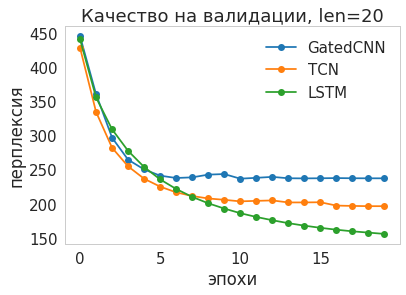

In [33]:
plt.plot(np.exp(gated_val_losses), marker='o', label ="GatedCNN")
plt.plot(np.exp(tcn_val_losses), marker='o', label ="TCN")
plt.plot(np.exp(lstm_val_losses), marker='o', label ="LSTM")
plt.xlabel('эпохи')
plt.ylabel('перплексия')
plt.title('Качество на валидации, len=20')
plt.legend()
plt.show()

Сравним время обучения:

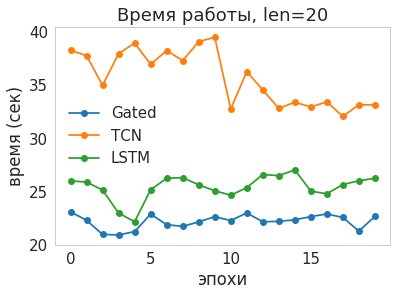

In [34]:
plt.plot(gated_epoch_time, marker='o', label ="Gated")
plt.plot(tcn_epoch_time, marker='o', label ="TCN")
plt.plot(lstm_epoch_time, marker='o', label ="LSTM")
plt.xlabel('эпохи')
plt.ylabel('время (сек)')
plt.title('Время работы, len=20')
plt.legend()
plt.show()

Для более длинных последовательностей:

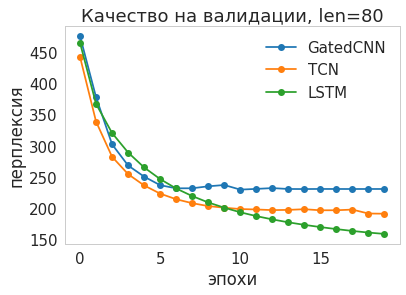

In [33]:
plt.plot(np.exp(gated_val_losses), marker='o', label ="GatedCNN")
plt.plot(np.exp(tcn_val_losses), marker='o', label ="TCN")
plt.plot(np.exp(lstm_val_losses), marker='o', label ="LSTM")
plt.xlabel('эпохи')
plt.ylabel('перплексия')
plt.title('Качество на валидации, len=80')
plt.legend()
plt.show()

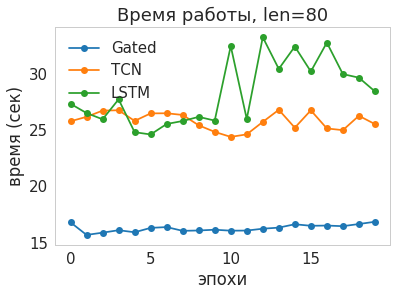

In [34]:
plt.plot(gated_epoch_time, marker='o', label ="Gated")
plt.plot(tcn_epoch_time, marker='o', label ="TCN")
plt.plot(lstm_epoch_time, marker='o', label ="LSTM")
plt.xlabel('эпохи')
plt.ylabel('время (сек)')
plt.title('Время работы, len=80')
plt.legend()
plt.show()

Самой быстрой моделью оказалася GatedCNN, правда, в ущерб качеству. TCN для длинных последовательностей работает быстрее, чем LSTM, однако на более коротких уступает в скорости и в качестве.